# Quality control

After spatial smoothing, generate a mean fMRI image for each subject, then a mean fMRI image across all subjects, and then correlate each subject's mean fMRI to the across-subjects' mean fMRI image.

In [1]:
# Load required packages
import nibabel as nib
import numpy as np
import os
import glob
from scipy.stats import pearsonr

In [2]:
os.chdir('/project/3013104.01/')

In [6]:
# Create a subject list
def get_directories_with_prefix(directory, prefix):
    matching_directories = []
    # Iterate over all entries in the directory
    for entry in os.listdir(directory):
        # Get the full path of the entry
        full_path = os.path.join(directory, entry)
        # Check if it is a directory and starts with the given prefix
        if os.path.isdir(full_path) and entry.startswith(prefix):
            matching_directories.append(entry)
    return matching_directories

# Provide the directory path and prefix
directory_path = '/project/3013104.01/analysis/smoothed/pulled-data-MRI'
prefix_to_match = 'subject-'

# Get the matching directories as a list
subject_list = get_directories_with_prefix(directory_path, prefix_to_match)

# Sort the list
subject_list.sort()

# Print the list of matching directories
print("Number of subjects to be used for mean fMRI calculation:", len(subject_list))
for subject in subject_list:
    print(subject)

Number of subjects to be used for mean fMRI calculation: 239
subject-0001
subject-0002
subject-0003
subject-0004
subject-0005
subject-0006
subject-0007
subject-0008
subject-0009
subject-0010
subject-0011
subject-0012
subject-0013
subject-0014
subject-0015
subject-0016
subject-0017
subject-0018
subject-0019
subject-0020
subject-0021
subject-0022
subject-0023
subject-0024
subject-0025
subject-0026
subject-0027
subject-0028
subject-0029
subject-0030
subject-0031
subject-0032
subject-0033
subject-0034
subject-0035
subject-0036
subject-0037
subject-0038
subject-0039
subject-0040
subject-0041
subject-0042
subject-0043
subject-0044
subject-0045
subject-0046
subject-0047
subject-0048
subject-0049
subject-0050
subject-0051
subject-0052
subject-0053
subject-0054
subject-0055
subject-0056
subject-0057
subject-0058
subject-0059
subject-0060
subject-0061
subject-0062
subject-0063
subject-0064
subject-0065
subject-0066
subject-0067
subject-0068
subject-0069
subject-0070
subject-0071
subject-0072
sub

## Generate a mean fMRI image for each subject and each session.

In [7]:
# Define the paths to directories
sub_directories = ['mri_movietask_1', 'mri_movietask_2', 'mri_movietask_3']
output_directory = '/project/3013104.01/analysis/mean_fMRI'
data_dir = '/project/3013104.01/analysis/smoothed/pulled-data-MRI'

# Specify the index to start the for-loop from
start_index = 85  # index to start from in subject_list

# Loop over the main directories
os.chdir(data_dir)
for index, subject in enumerate(subject_list[start_index:], start=start_index):
#for subject in subject_list:
    # Loop over the subdirectories
    for sub_dir in sub_directories:
        # Create the full path to the subdirectory
        sub_dir_path = os.path.join(subject, sub_dir)
        
        # Match the .nii.gz files in the subdirectory
        file_pattern = os.path.join(sub_dir_path, '*.nii.gz')
        nii_files = glob.glob(file_pattern)
        
        # Loop over the matched .nii.gz files
        for nii_file in nii_files:
            # Load the NIfTI image
            nii_img = nib.load(nii_file)
            
            # Get the image data as a NumPy array
            img_data = nii_img.get_fdata()
            
            # Calculate the mean along the time dimension
            mean_img_data = np.mean(img_data, axis=-1)
            
            # Create the output directory if it doesn't exist
            os.makedirs(output_directory, exist_ok=True)
            
            # Extract the file name without extension
            file_name = os.path.splitext(os.path.basename(nii_file))[0]
            
            # Construct the output file name with subject and subdirectory
            output_file = f"{subject}_{sub_dir}_{file_name}_mean.nii.gz"
            
            # Save the mean image as a new NIfTI file
            output_path = os.path.join(output_directory, output_file)
            mean_nii_img = nib.Nifti1Image(mean_img_data, nii_img.affine, nii_img.header)
            nib.save(mean_nii_img, output_path)

## Generate mean fMRI image across all subjects and sessions.

In [8]:
# Specify the directory containing the .nii.gz files
directory = output_directory
os.chdir(directory)

# Get a list of all .nii.gz files in the directory
file_list = [f for f in os.listdir(directory) if f.endswith(".nii.gz")]

# Initialize an empty array to store voxel values
voxel_data = None

# Iterate over each file
for file_name in file_list:
    file_path = os.path.join(directory, file_name)
    
    # Load the .nii.gz file
    img = nib.load(file_path)
    data = img.get_fdata()
    
    # Add voxel data to the array
    if voxel_data is None:
        voxel_data = data
    else:
        voxel_data += data

# Compute the mean voxel data
mean_data = voxel_data / len(file_list)

# Create a NIfTI image object for the mean data
mean_img = nib.Nifti1Image(mean_data, img.affine, img.header)

# Save the mean image to a file
output_path = "mean_fMRI.nii.gz"
nib.save(mean_img, output_path)

print("Mean fMRI image saved to:", output_path)

Mean fMRI image saved to: mean_fMRI.nii.gz


## Calculate correlations between each subject-session mean fMRI and the across-subjects mean fMRI.

In [10]:
def correlate_nii_files(directory, search_string, reference_file, output_file):
    # Find all files in the directory that match the search string
    file_list = glob.glob(os.path.join(directory, f"*{search_string}*.nii.gz"))

    # Load the reference file
    reference_data = nib.load(reference_file).get_fdata()

    # Open the output file in write mode
    with open(output_file, 'w') as f:
        # Iterate over each file in the file list
        for file_path in file_list:
            # Load the current file
            current_data = nib.load(file_path).get_fdata()

            # Calculate the correlation coefficient and p-value
            correlation, p_value = pearsonr(reference_data.flatten(), current_data.flatten())

            # Write the file name, correlation coefficient, and p-value to the output file
            f.write(f"{file_path},")
            f.write(f"{correlation},")
            f.write(f"{p_value}\n")

# Set the directory path, search string, reference file path, and output file path
directory_path = output_directory
search_string = "subject-"
reference_file_path = output_path
output_file_path = "correlations_to_mean.csv"

# Call the function to correlate the files and save the output to the file
correlate_nii_files(directory_path, search_string, reference_file_path, output_file_path)

## Plot correlations

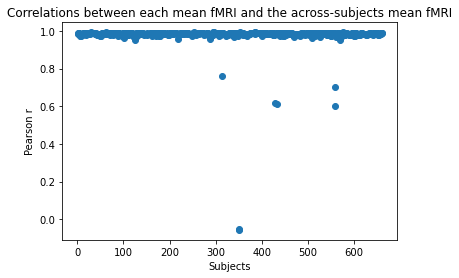

r < 0.8:
                                                                                                                      Outliers
312  /project/3013104.01/analysis/mean_fMRI/subject-0114_mri_movietask_3_smoothed_filtered_func_data_clean_MNI.nii_mean.nii.gz
349  /project/3013104.01/analysis/mean_fMRI/subject-0128_mri_movietask_2_smoothed_filtered_func_data_clean_MNI.nii_mean.nii.gz
350  /project/3013104.01/analysis/mean_fMRI/subject-0128_mri_movietask_3_smoothed_filtered_func_data_clean_MNI.nii_mean.nii.gz
427  /project/3013104.01/analysis/mean_fMRI/subject-0157_mri_movietask_1_smoothed_filtered_func_data_clean_MNI.nii_mean.nii.gz
431  /project/3013104.01/analysis/mean_fMRI/subject-0158_mri_movietask_2_smoothed_filtered_func_data_clean_MNI.nii_mean.nii.gz
557  /project/3013104.01/analysis/mean_fMRI/subject-0203_mri_movietask_1_smoothed_filtered_func_data_clean_MNI.nii_mean.nii.gz
558  /project/3013104.01/analysis/mean_fMRI/subject-0203_mri_movietask_2_smoothed_filtered_func_data_c

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'correlations_to_mean.csv'

# Import CSV file using Pandas without headers
df = pd.read_csv(file_path, header=None)

# Column with values to plot
second_column_values = df.iloc[:, 1]

# Filter rows where the second column value is less than 0.8
filtered_rows = df[df.iloc[:, 1] < 0.8]

# Extract values from the first column for the filtered rows
first_column_filtered_values = filtered_rows.iloc[:, 0]

# Create a scatter plot using Matplotlib
plt.scatter(range(1, len(second_column_values) + 1), second_column_values)

# Add labels and a title
plt.xlabel('Subjects')
plt.ylabel('Pearson r')
plt.title('Correlations between each mean fMRI and the across-subjects mean fMRI')

# Display the plot
plt.show()

# Output the filtered values from the first column into a table
if not first_column_filtered_values.empty:
    table_data = pd.DataFrame({"Outliers": first_column_filtered_values})
    pd.set_option("max_colwidth", None)  # Display entire contents of each cell
    print("r < 0.8:")
    print(table_data)
else:
    print("No r values found < 0.8.")

The outliers above should be added to the excluded list of subject data.